<h1> HW3 </h1>

## Q1.a

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as T
import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Merge, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from time import time
import multiprocessing as mp
import sys
import math
import argparse
import matplotlib.pyplot as plt

Define dataset folder and files

In [ ]:
MOVIELENS_DIR = 'ml-100k/'
RATING_DATA_FILE = 'u1.base'
RATINGS_CSV_FILE = 'u1_emb.data'
MODEL_WEIGHTS_FILE = 'u1_emb_weights.h5'

The user and item id for embedding should start from 0.
Update ids and save to file

In [ ]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(str(len(ratings))+' ratings loaded')
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['userid', 'movieid', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])
print('Saved to '+RATINGS_CSV_FILE)

Load train rating file

In [ ]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print(str(len(ratings)), 'ratings loaded.')
print('users '+str(max_userid)+' items '+str(max_movieid))

In [ ]:
print(ratings)

Prepare inputs to model

In [ ]:
shuffled_ratings = ratings.sample(frac=1.)
Users = shuffled_ratings['user_emb_id'].values
Movies = shuffled_ratings['movie_emb_id'].values
Ratings = shuffled_ratings['rating'].values

In [ ]:
shuffled_ratings

Define matrix factorization model

In [ ]:
def get_model(num_users, num_items, latent_dim):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # 2 dropuot
    conc = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    # Element-wise product of user and item embeddings
    prediction = merge([user_latent, item_latent], mode = 'dot')
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model


Define embedding size and compile model

In [ ]:
K_LATENT = 20
hidden_dim = 1
do = 0.5

MF_model = get_model(max_userid,max_movieid,K_LATENT)
MF_model.compile(loss='mse', optimizer='adamax',metrics=['mae'])

## Q1.b

Train model

In [ ]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyMF = MF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

In [ ]:
def printSumMSE(history):
    loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                         'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                         'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})

    plt.plot(loss['training'])
    plt.plot(loss['validation'])
    plt.title('model rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
printSumMSE(historyMF)

### Second Model: TODO

## Q1.c

In HW2 we got MAE 0.5956766082578648, in one epoc.
in HW3 we got MAE 0.9192 in 12 epoches
We can understand from above that our pediction model worked better, because we based on non-personal recomandations.



## Q2.a

In [ ]:
def get_ncf_model(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    conc = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model

In [ ]:
K_LATENT = 20
hidden_dim = 1
do = 0.5

NCF_model = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

## Q2.b

### option 1: 1 hidden layer, K_LATENT(output_dim) = 20, optimizer=Adamax(), loss='mse', activation='relu'.

In [ ]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF = NCF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

In [ ]:
printSumMSE(historyNCF)

### option 1 result: mean_absolute_error: 0.8654

### option2 : 10 hidden layer, K_LATENT(output_dim) = 20, optimizer=Adamax(), loss='mse', activation='relu'.

In [ ]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_model2 = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model2.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

In [ ]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF2 = NCF_model2.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

In [ ]:
printSumMSE(historyNCF2)

### option 2 result: We got mean_absolute_error: 0.7487

### option 3 : 5 hidden layer, K_LATENT(output_dim) = 10, optimizer=Adamax(), loss='mse', activation='relu'.

In [ ]:
K_LATENT = 10
hidden_dim = 5
do = 0.5

NCF_model3 = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model3.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

In [ ]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF3 = NCF_model3.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

In [ ]:
printSumMSE(historyNCF3)

### option 3 result : mean_absolute_error: 0.7639


## Q2.c

## summary:
### option 1 MAE 0.8654
### option 2 MAE 0.7487
### option 3 MAE 0.7639

### So the best is option2!:
### 10 hidden layer, K_LATENT(output_dim) = 20, optimizer=Adamax(), loss='mse', activation='relu'.

#### explanation:                                                                                                                                                                                                      
#### in the neural network, the number of hidden layers is the number of layers that the data is processed. therefore more layers can improve the accuracy of the prediction.   

## Q3.1

### add gender and release year

## Q3.2


In [ ]:
m_cols = ['movieid','movie title','release date','video release date','IMDb URL'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
data_u_item = pd.read_csv('ml-100k/u.item',delimiter='|',names=m_cols,encoding='latin-1')[['movieid','release date']]

In [ ]:
#explore users
u_cols = ['userid','age','gender','occupation','zip_code']
data_u_users = pd.read_csv('ml-100k/u.user',delimiter='|',names=u_cols,encoding='latin-1')[['userid','gender']]

### merge shuffled_ratings with movie info and user information

In [ ]:
data_u_item.head()

In [ ]:
data_u_users.head()

In [ ]:
shuffled_ratings.head()

In [ ]:
movies_ratings_data = shuffled_ratings.merge(data_u_item,on = 'movieid',how = 'inner')

In [ ]:
movies_ratings_data = movies_ratings_data.merge(data_u_users,on = 'userid',how = 'inner')

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
movies_ratings_data['gender'] = lb.fit_transform(movies_ratings_data['gender'])

In [ ]:
def parse_date(data):
    new_data = []
    for year in data:
        fix_year = year[-4:]
        new_data.append(fix_year)
    return new_data

In [ ]:
# movies_ratings_data['release date'] = parse_date(movies_ratings_data['release date']) 
movies_ratings_data.loc[movies_ratings_data['release date'].isnull(), 'release date'] = '1990'
movies_ratings_data.loc[movies_ratings_data['release date'] == '','release date'] = '1990'
movies_ratings_data['release date'] = parse_date(movies_ratings_data['release date']) 

In [ ]:
movies_ratings_data.head()

In [ ]:
Users = movies_ratings_data['user_emb_id'].values
Movies = movies_ratings_data['movie_emb_id'].values
Gender = movies_ratings_data['gender'].values
Year = movies_ratings_data['release date'].values
Ratings = movies_ratings_data['rating'].values

In [333]:
def get_ncf_model_4(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    gender_input = Input(shape=(1,), dtype='int32', name = 'gender_input')
    year_input = Input(shape=(1,), dtype='int32', name = 'year_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1) 
    MF_Embedding_Gender = Embedding(input_dim = 2, output_dim = latent_dim, name = 'gender_embedding', input_length=1)
    MF_Embedding_Year = Embedding(input_dim = 2000, output_dim = latent_dim, name = 'year_embedding', input_length=1)  
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    gender_latent = Flatten()(MF_Embedding_Gender(gender_input))
    year_latent = Flatten()(MF_Embedding_Year(year_input))
    
    # Element-wise product of user and item embeddings
    conc = Concatenate()([user_latent, item_latent, gender_latent, year_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input, gender_input, year_input], output=prediction)

    return model

In [345]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_modelQ3 = get_ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_modelQ3.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


### Q3,c

### option 1 K_LATENT = 20, hidden_dim = 10

In [346]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCFQ3 = NCF_modelQ3.fit([Users, Movies, Gender, Year], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 7s 112us/step - loss: 2.5308 - mean_absolute_error: 1.2704 - val_loss: 1.4122 - val_mean_absolute_error: 0.9972
Epoch 2/12
64000/64000 [==============================] - 7s 106us/step - loss: 1.3523 - mean_absolute_error: 0.9371 - val_loss: 1.2535 - val_mean_absolute_error: 0.9333
Epoch 3/12
64000/64000 [==============================] - 6s 100us/step - loss: 1.0277 - mean_absolute_error: 0.8142 - val_loss: 1.1752 - val_mean_absolute_error: 0.8966
Epoch 4/12
64000/64000 [==============================] - 7s 105us/step - loss: 0.9551 - mean_absolute_error: 0.7806 - val_loss: 1.1396 - val_mean_absolute_error: 0.8776
Epoch 5/12
64000/64000 [==============================] - 6s 100us/step - loss: 0.9337 - mean_absolute_error: 0.7707 - val_loss: 1.1330 - val_mean_absolute_error: 0.8757
Epoch 6/12
64000/64000 [==============================] - 6s 101us/step - loss: 0.9260 - mean_absolu

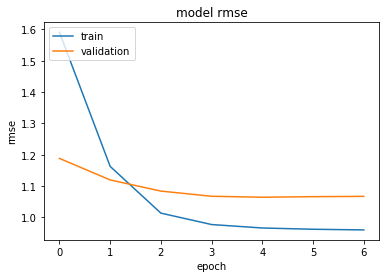

In [347]:
printSumMSE(historyNCFQ3)

### option2 K_LATENT = 20, hidden_dim = 10 optimizer=Adagrad

In [359]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_modelQ3 = get_ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_modelQ3.compile(loss='mse',optimizer=Adagrad(),metrics=['mae'])
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCFQ3 = NCF_modelQ3.fit([Users, Movies, Gender, Year], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 8s 121us/step - loss: 2.4136 - mean_absolute_error: 1.2473 - val_loss: 1.5247 - val_mean_absolute_error: 1.0449
Epoch 2/12
64000/64000 [==============================] - 7s 106us/step - loss: 1.9676 - mean_absolute_error: 1.1256 - val_loss: 1.3797 - val_mean_absolute_error: 0.9864
Epoch 3/12
64000/64000 [==============================] - 7s 105us/step - loss: 1.7988 - mean_absolute_error: 1.0745 - val_loss: 1.3758 - val_mean_absolute_error: 0.9861
Epoch 4/12
64000/64000 [==============================] - 7s 106us/step - loss: 1.6955 - mean_absolute_error: 1.0452 - val_loss: 1.3344 - val_mean_absolute_error: 0.9686
Epoch 5/12
64000/64000 [==============================] - 7s 104us/step - loss: 1.5908 - mean_absolute_error: 1.0125 - val_loss: 1.3503 - val_mean_absolute_error: 0.9760
Epoch 6/12
64000/64000 [==============================] - 7s 103us/step - loss: 1.5056 - mean_absolu

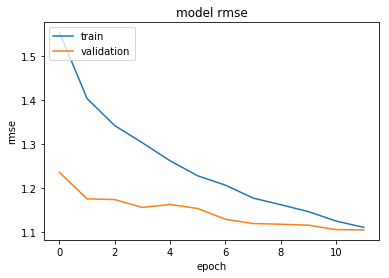

In [360]:
printSumMSE(historyNCFQ3)

# option3 K_LATENT = 10, hidden_dim = 20 optimizer=SGD :

In [365]:
K_LATENT = 10
hidden_dim = 10
do = 0.5

NCF_modelQ3 = get_ncf_model_4(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_modelQ3.compile(loss='mse',optimizer=SGD(),metrics=['mae'])
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCFQ3 = NCF_modelQ3.fit([Users, Movies, Gender, Year], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

C:\Users\erez\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 6s 101us/step - loss: 1.3913 - mean_absolute_error: 0.9695 - val_loss: 1.2140 - val_mean_absolute_error: 0.9312
Epoch 2/12
64000/64000 [==============================] - 5s 81us/step - loss: 1.1903 - mean_absolute_error: 0.9037 - val_loss: 1.1946 - val_mean_absolute_error: 0.9165
Epoch 3/12
64000/64000 [==============================] - 6s 87us/step - loss: 1.1146 - mean_absolute_error: 0.8616 - val_loss: 1.1623 - val_mean_absolute_error: 0.8914
Epoch 4/12
64000/64000 [==============================] - 5s 83us/step - loss: 1.0518 - mean_absolute_error: 0.8269 - val_loss: 1.1222 - val_mean_absolute_error: 0.8593
Epoch 5/12
64000/64000 [==============================] - 5s 85us/step - loss: 1.0200 - mean_absolute_error: 0.8114 - val_loss: 1.1101 - val_mean_absolute_error: 0.8535
Epoch 6/12
64000/64000 [==============================] - 6s 88us/step - loss: 0.9996 - mean_absolute_er

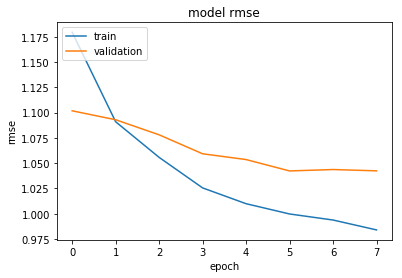

In [366]:
printSumMSE(historyNCFQ3)